# Sequence models

Finally, we arrive a sequence models. Hopefully this will serve us better than the convolutional approach (but why would it?).

## 1. RNN for input-output with equal length
```
Input: pianoroll-unit (128, 96)
Output: pianoroll-unit (128, 96)
```

### Layers = 1, Hidden Size = 128
Epoch 50: `loss: 0.0022 - acc: 0.5142 - val_loss: 0.0026 - val_acc: 0.4837`

### Layers = 2, Hidden Size = 128
Epoch 50: `loss: 0.0027 - acc: 0.4919 - val_loss: 0.0031 - val_acc: 0.4702`

### Layers = 1, Hidden Size = 256
Epoch 50: `loss: 0.0023 - acc: 0.5242 - val_loss: 0.0027 - val_acc: 0.4984`

Code adapted from: https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [3]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import load_model

PICKLE_FILE = './pickle_jar/norm_units_50_songs.pkl'

In [4]:
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )
units['full'] = units['input'] + units['comp']

# Print info
print("Loaded", units["input"].shape[0], "units from", PICKLE_FILE)
print("input_units.shape: ", units["input"].shape)
print("comp_units.shape: ", units["comp"].shape)
print("full_units.shape: ", units["full"].shape)

# Create an array of True (train) and False (test) to split the dataset
train_test_indices = np.random.choice([True, False], size=len(units["input"]), p=[.9, .1])
# Training data
input_train = units["input"][train_test_indices, ...].swapaxes(1,2)
comp_train = units["comp"][train_test_indices, ...].swapaxes(1,2)
full_train = units["full"][train_test_indices, ...].swapaxes(1,2)
# Testing data
input_test = units["input"][np.invert(train_test_indices), ...].swapaxes(1,2)
comp_test = units["comp"][np.invert(train_test_indices), ...].swapaxes(1,2)
full_test = units["full"][np.invert(train_test_indices), ...].swapaxes(1,2)
print("Train:", input_train.shape)
print("Test:", input_test.shape)

('Loaded', 3268, 'units from', './pickle_jar/norm_units_50_songs.pkl')
('input_units.shape: ', (3268, 128, 96))
('comp_units.shape: ', (3268, 128, 96))
('full_units.shape: ', (3268, 128, 96))
('Train:', (2935, 96, 128))
('Test:', (333, 96, 128))


In [ ]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
NUM_TICKS = 96
NUM_PITCHES = 128
REVERSE = True

MAXLEN = NUM_TICKS

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, NUM_PITCHES)))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(MAXLEN))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(NUM_PITCHES)))
model.add(layers.Activation('tanh'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [38]:
# Train the model each generation and show predictions against the validation
# dataset.

model.fit(input_train, input_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/rnn')])

MODEL_RNN_V1_FILE = './models/rnn_v1.h5'
model.save(MODEL_RNN_V1_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_RNN_V1_FILE)

Train on 2935 samples, validate on 333 samples
Epoch 1/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0046 - acc: 0.3970 - val_loss: 0.0046 - val_acc: 0.4170
Epoch 2/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0044 - acc: 0.4097 - val_loss: 0.0045 - val_acc: 0.4245
Epoch 3/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0043 - acc: 0.4138 - val_loss: 0.0044 - val_acc: 0.4282
Epoch 4/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0042 - acc: 0.4242 - val_loss: 0.0043 - val_acc: 0.3930
Epoch 5/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0041 - acc: 0.4273 - val_loss: 0.0043 - val_acc: 0.4511
Epoch 6/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0040 - acc: 0.4344 - val_loss: 0.0042 - val_acc: 0.3932
Epoch 7/50
2935/2935 [==============================] - 21s 7ms/step - loss: 0.0040 - acc: 0.4361 - val_loss: 0.0041 - val_acc: 0.4113
Epoch 8/

In [5]:
MODEL_RNN_V1_FILE = './models/rnn_v1.h5'
model = load_model(MODEL_RNN_V1_FILE)

In [39]:
# Run test inputs through the autoencoder
decoded_test = model.predict(input_test)
print(decoded_test.shape)

(333, 96, 128)


(96, 128)
(96, 128)
(96, 128)


ValueError: data byte must be in range 0..127

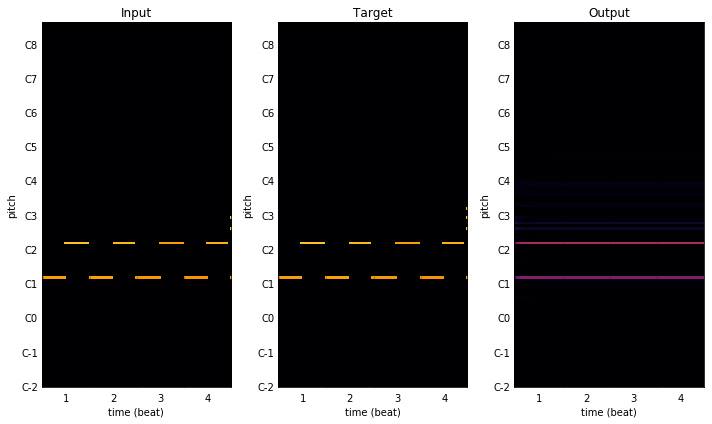

In [41]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index] * 127
sample_full = full_test[sample_index] * 127
sample_output = decoded_test[sample_index] * 127

# Set all velocity values < threshold to zero
# sample_output[sample_output < 10] = 0

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_full, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_full)
# pianoroll_utils.playPianoroll(sample_output)
pianoroll_utils.playPianoroll_events(sample_output.swapaxes(0,1))

